In [1]:
#%matplotlib widget
from tqdm.auto import tqdm, trange
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from numpy.random import default_rng, SeedSequence
import multiprocessing
import concurrent.futures
from numba import vectorize,jit,prange,objmode,njit
from bentley_ottmann.planar import edges_intersect

In [2]:
rng = default_rng()

In [3]:
error = 1e-10 #because machine error is *really* important when working with linalg

In [4]:
def normalize(v):
    l = np.linalg.norm(v)
    if l < error:
        print("Something has gone terribly wrong with "+str(v))
        return v
    return v/l

In [5]:
def polar_poly(r,n):
    r = np.vectorize(r)
    theta = 2*np.pi/n
    angles = np.array([x*theta for x in range(n)])
    p0s = np.vstack((r(angles)*np.cos(angles),r(angles)*np.sin(angles))).T
    p1s = np.array(list(map(lambda i: p0s[(i+1)%n],range(n))))
    return np.array(list(zip(p0s,p1s)))

In [6]:
#from https://stackoverflow.com/a/45372025

def is_convex_polygon(polygon):
    """Return True if the polynomial defined by the sequence of 2D
    points is 'strictly convex': points are valid, side lengths non-
    zero, interior angles are strictly between zero and a straight
    angle, and the polygon does not intersect itself.

    NOTES:  1.  Algorithm: the signed changes of the direction angles
                from one side to the next side must be all positive or
                all negative, and their sum must equal plus-or-minus
                one full turn (2 pi radians). Also check for too few,
                invalid, or repeated points.
            2.  No check is explicitly done for zero internal angles
                (180 degree direction-change angle) as this is covered
                in other ways, including the `n < 3` check.
    """
    try:  # needed for any bad points or direction changes
        # Check for too few points
        if len(polygon) < 3:
            return False
        # Get starting information
        old_x, old_y = polygon[-2]
        new_x, new_y = polygon[-1]
        new_direction = np.arctan2(new_y - old_y, new_x - old_x)
        angle_sum = 0.0
        # Check each point (the side ending there, its angle) and accum. angles
        for ndx, newpoint in enumerate(polygon):
            # Update point coordinates and side directions, check side length
            old_x, old_y, old_direction = new_x, new_y, new_direction
            new_x, new_y = newpoint
            new_direction = np.arctan2(new_y - old_y, new_x - old_x)
            if old_x == new_x and old_y == new_y:
                return False  # repeated consecutive points
            # Calculate & check the normalized direction-change angle
            angle = new_direction - old_direction
            if angle <= -np.pi:
                angle += 2*np.pi  # make it in half-open interval (-Pi, Pi]
            elif angle > np.pi:
                angle -= np.pi
            if ndx == 0:  # if first time through loop, initialize orientation
                if angle == 0.0:
                    return False
                orientation = 1.0 if angle > 0.0 else -1.0
            else:  # if other time through loop, check orientation is stable
                if orientation * angle <= 0.0:  # not both pos. or both neg.
                    return False
            # Accumulate the direction-change angle
            angle_sum += angle
        # Check that the total number of full turns is plus-or-minus 1
        return np.abs(np.around(angle_sum / (2*np.pi))) == 1
    except (ArithmeticError, TypeError, ValueError):
        return False  # any exception means not a proper convex polygon

In [7]:
# from https://matlabgeeks.com/tips-tutorials/computational-geometry/creating-2-d-polygons-in-matlab/
def rand_ngon(n,radVar=1,angVar=1):
    angles = np.arange(n)*(2*np.pi/n)
    
    xs = (1+rng.random(size=n)*radVar)*np.cos(angles+rng.random(size=n)*angVar)
    ys = (1+rng.random(size=n)*radVar)*np.sin(angles+rng.random(size=n)*angVar)
    
    vs = list(zip(xs,ys))
    simple = not edges_intersect(vs)
    
    p0s = np.array(vs)
    convex = is_convex_polygon(p0s)
    p1s = p0s[np.mod(np.arange(n)+1,n)]
    
    return np.array(list(zip(p0s,p1s))),convex,simple

In [8]:
def rand_convex(n,randVar=1,angVar=1):
    convex = False
    while not convex:
        shape,convex,_ = rand_ngon(n,randVar,angVar)
    return shape
def rand_concave(n,randVar=1,angVar=1):
    convex = True
    simple = True
    while convex or not simple:
        shape,convex,simple = rand_ngon(n,randVar,angVar)
    return shape
def rand_simple(n,randVar=1,angVar=1):
    simple = False
    while not simple:
        shape,convex,simple = rand_ngon(n,randVar,angVar)
    return shape,convex

False


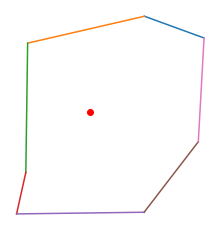

In [9]:
n = 7
fig = plt.figure()
shape,convex = rand_simple(n)
print(convex)
plt.plot(*shape.T)
plt.gca().set_aspect(1)
plt.plot(0,0,'ro')
plt.axis('off')
plt.show()

In [10]:
#@njit(fastmath=True,parallel=True)
def line_hit(x,v,p0,p1):
    dp = p0-p1#np.subtract(p0,p1)
    a = np.vstack((v,dp)).T
    b = p0-x#np.subtract(p0,x)
    t = np.linalg.solve(a,b)
    nx = x+t[0]*v #np.add(x,np.multiply(t[1],v))
    p = p0-t[1]*dp#np.add(p0,np.multiply(t[0],dp))
    if t[1] < 1 and t[1] > 0 and t[0] > 0 and np.linalg.norm(p-nx) < error:
        n = np.array([-dp[1],dp[0]])
        return True, (p,n,(x,v,t[0]))
    else:
        return False, ()

In [11]:
#@jit(fastmath=True,parallel=True,forceobj=True)
def general_hit(hits):
    #crossings = hits[:,0,[1,2]]
    crossings = list(map(lambda x: (x[1],x[2]), filter(lambda x: x[0], hits)))
    #crossings = hits[:][0][[1,2]]
    if crossings == []:
        raise Exception("No hits!")
    cross = sorted(crossings,key=lambda x: x[0][2][2])[0]
    p = cross[0][0]
    n = cross[0][1]
    s = cross[1]
    t = cross[0][2][2]
    return p, n, s, t

In [12]:
def polygon_hit(ps):
    def hit(x,v):
        hits = list(map(lambda p: line_hit(x,v,*p[1])+(p[0],),enumerate(ps))) #append i to the side
        return general_hit(hits)
    return hit

In [13]:
def bounce(v,n):
    n = normalize(n)
    return v-2*np.dot(n,v)*n

In [14]:
def sim(hitFunc,x,v,depth):
    xs = np.zeros((depth+1,2))
    vs = np.zeros((depth+1,2))
    ss = np.zeros(depth)
    ts = np.zeros(depth)
    xs[0] = x
    vs[0] = v
    ss[0] = -1
    ts[0] = -1
    for i in range(depth):
        x, n, s, t = hitFunc(x,v)
        v = bounce(v,n)
        xs[i+1] = x
        vs[i+1] = v
        ss[i] = s
        ts[i] = t
        x = x+error*v
    return xs,vs,ss,ts

In [15]:
def dynamical_sim(hitFunc,x,v,side,depth):
    xs,vs,ss,ts = sim(hitFunc,x,v,depth)
    return ts[ss==side]

In [16]:
def randx(rad):
    r = rng.random()*rad
    theta = 2*np.pi*rng.random()
    x = np.multiply(r,np.array([np.cos(theta),np.sin(theta)]))
    return x
def randv():
    vtheta = 2*np.pi*rng.random()
    v = np.array([np.cos(vtheta),np.sin(vtheta)])
    return v

In [17]:
# from my chaos pset
@njit(fastmath=True,parallel=True)
def chaos_test(time_series):
    c = 2
    bign = time_series.size
    path = np.zeros((bign+1,2))
    with objmode():
        path[0] = np.array([rng.random()*5,rng.random()*5])
    for n,phi in enumerate(time_series):
        path[n+1] = path[n]+phi*np.array([np.cos(c*n),np.sin(c*n)])
    ps = path[:,0]
    qs = path[:,1]
    n = np.int_(0.1*bign)
    ks = np.arange(n)
    dks = np.zeros_like(ks)
    expectphisq = (np.sum(time_series)/time_series.size)**2
    for k in range(n):
        j = np.arange(bign-k)+1
        mk = (1/(bign-k))*np.sum((ps[j+k]-ps[j])**2+(qs[j+k]-qs[j])**2)
        dks[k] = mk-expectphisq*(1-np.cos(k*c))/(1-np.cos(c))
    dks = dks + 1.1*np.abs(np.min(dks))
    with objmode(fit='f8[:]'):
        fit = np.polyfit(np.log(ks+1),np.log(dks+1),1)
    return fit[0],path,ks,dks

In [18]:
n = 4
vex = rand_convex(n)
vexhit = polygon_hit(vex)
cav = rand_concave(n)
cavhit = polygon_hit(cav)

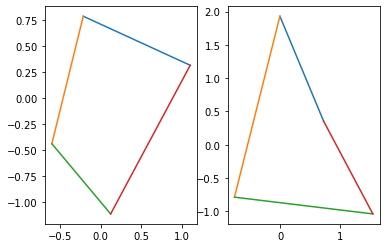

In [19]:
fig,(ax0,ax1) = plt.subplots(1,2)
ax0.plot(*vex.T)
ax1.plot(*cav.T)

In [20]:
dynvex = dynamical_sim(vexhit,randx(0.5),randv(),0,10000)
dyncav = dynamical_sim(cavhit,randx(0.5),randv(),0,10000)

In [21]:
chaosvex,pvex,kvex,mvex = chaos_test(dynvex)
chaoscav,pcav,kcav,mcav = chaos_test(dyncav)

C:\Users\torri\miniconda3\lib\site-packages\numba\core\dispatcher.py:238: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


Convex 0.9401765845454128
Concave 1.0189481963566474


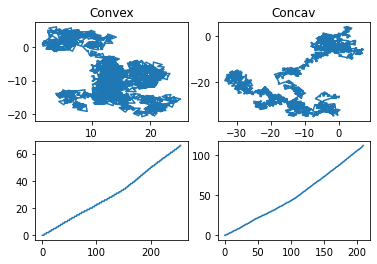

In [22]:
fig,(ax0,ax1) = plt.subplots(2,2)
ax0[0].set_title("Convex")
ax0[0].plot(*pvex.T)
ax0[1].set_title("Concav")
ax0[1].plot(*pcav.T)
ax1[0].plot(kvex,mvex)
ax1[1].plot(kcav,mcav)
print("Convex",chaosvex)
print("Concave",chaoscav)

In [23]:
def chaos_sims(trials,sides,depth):
    chaos,vexs = np.zeros(trials),np.zeros(trials)
    for i in trange(trials):
        shape,convex = rand_simple(sides)
        vexs[i] = convex
        hit = polygon_hit(shape)
        try:
            dyn = dynamical_sim(hit,randx(0.5),randv(),0,depth)
            chaos[i],_,_,_ = chaos_test(dyn)
        except:
            chaos[i] = -1
    return chaos,vexs

In [ ]:
trials = 1000
depth = 5000
sides = np.array([4,5,6,7,8,9,10])
cz,vz,mask = np.zeros((sides.size,trials)),np.zeros((sides.size,trials)),np.zeros((sides.size,trials))
for i,s in enumerate(sides):
    cz[i],vz[i] = chaos_sims(trials,s,depth)
    vz[i] = vz[i] != 0
    mask[i] = cz[i] != -1

C:\Users\torri\miniconda3\lib\site-packages\numpy\lib\polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


In [ ]:
for i,s in enumerate(sides):
    c = cz[i,mask[i]]
    v = vz[i,mask[i]]
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
    axs[0].set_title("Convex")
    axs[0].hist(c[v], bins=n_bins)
    axs[1].set_title("Concave")
    axs[1].hist(c[np.logical_not(v)], bins=n_bins)
    axs[2].set_title("Combined")
    axs[2].hist(c, bins=n_bins)
    plt.savefig("{}chaos.png".format(s))